# Cats with GAN

## Model Objectives 

1. Implement GAN for cat face data
2. Use appropriate scoring metrics to compare the performance

## Cats data

Throughout this project, we'll be working with the Kaggle repository, [Cats faces 64x64](https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models), which contains 15,700 color images of cat faces.

In [2]:
import os

import cv2 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder as ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

%matplotlib inline

In [4]:
# Read and preprocess all data
image_size = 64
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(
    "./data",
    transform=tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)
        ])
    )

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

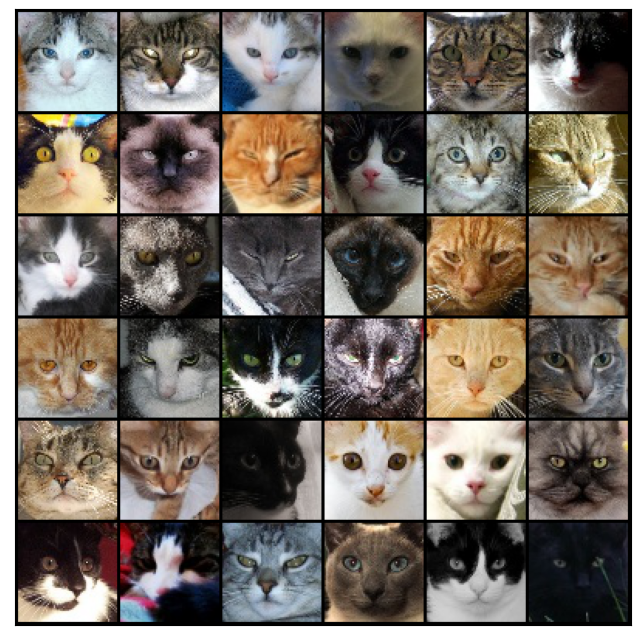

In [5]:
def denormalize(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=36):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=6).permute(1, 2, 0))

def show_batch(dl, nmax=36):
    for images, _ in dl:
        show_images(images)
        break

show_batch(train_dl)

In [6]:
print('torch.cuda.is_available()', torch.cuda.is_available())

torch.cuda.is_available() False


# Model definition

In [6]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [7]:
latent_size = 255

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

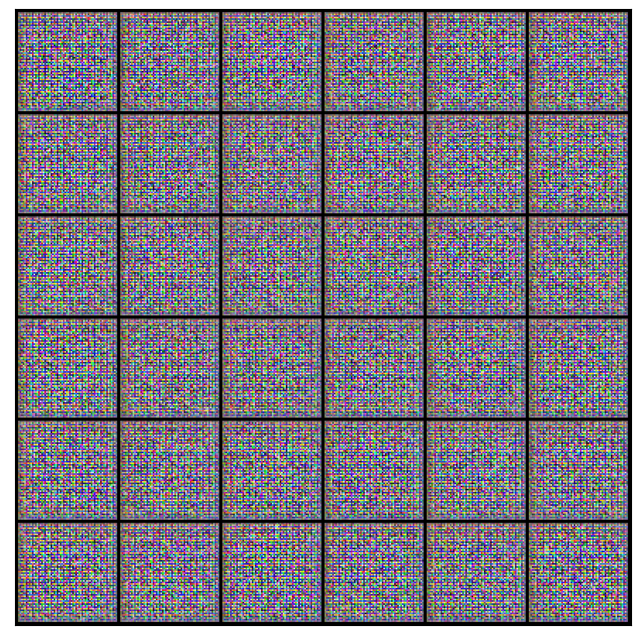

In [9]:
# Generate cats using untrained NN - we obtain random noise
random_latent = torch.randn(36, latent_size, 1, 1) # random latent tensors
fake_images = generator(random_latent)
show_images(fake_images)

In [10]:
def fit_discriminator(real_images, optimizer_d):

    # Clear discriminator gradients
    optimizer_d.zero_grad()

    # Check how well discriminator recognizes real images
    real_predictions = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1)
    real_loss = F.binary_cross_entropy(real_predictions, real_targets)
    real_score = torch.mean(real_predictions).item()
    
    # Generate fake images
    random_input = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(random_input)

    # Check how well discriminator recognizes fake images
    fake_predictions = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1)
    fake_loss = F.binary_cross_entropy(fake_predictions, fake_targets)
    fake_score = torch.mean(fake_predictions).item()

    # Correct discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_d.step()
    return loss.item(), real_score, fake_score

In [11]:
def fit_generator(optimizer_g):
    
    # Clear generator gradients
    optimizer_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1)
    fake_images = generator(latent)
    
    # Check if you can fool the discriminator
    predictions = discriminator(fake_images)
    targets = torch.ones(batch_size, 1)
    loss = F.binary_cross_entropy(predictions, targets)
    
    # Correct generator weights
    loss.backward()
    optimizer_g.step()
    
    return loss.item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


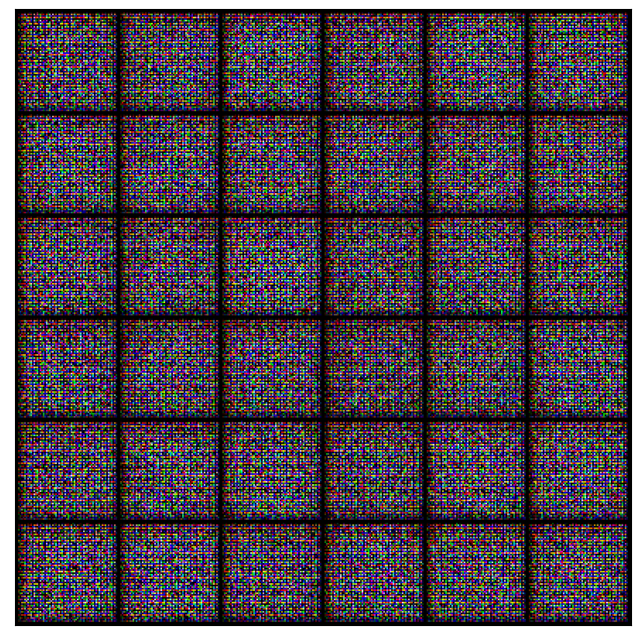

In [12]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_generated(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denormalize(fake_images), os.path.join(sample_dir, fake_fname), nrow=6)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=6).permute(1, 2, 0))

fixed_latent = torch.randn(36, latent_size, 1, 1)
save_generated(0, fixed_latent)

In [13]:
def train(epochs, learning_rate, start_idx=1):
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = fit_discriminator(real_images, optimizer_d)
            loss_g = fit_generator(optimizer_g)
        
        # Print losses and scores
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
            
        # Save losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
    
        # Save generated images
        save_generated(epoch + start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [14]:
learning_rate = 0.0002
epochs = 60

In [15]:
history = train(epochs, learning_rate, start_idx=0)   

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 14.2514, loss_d: 1.9699, real_score: 0.9596, fake_score: 0.8359
Saving generated-images-0000.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 5.4474, loss_d: 0.1112, real_score: 0.9637, fake_score: 0.0670
Saving generated-images-0001.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 4.5433, loss_d: 1.0491, real_score: 0.9130, fake_score: 0.5684
Saving generated-images-0002.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 2.6186, loss_d: 0.6760, real_score: 0.7179, fake_score: 0.2490
Saving generated-images-0003.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 4.9516, loss_d: 0.9427, real_score: 0.8350, fake_score: 0.4520
Saving generated-images-0004.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 1.1015, loss_d: 0.9820, real_score: 0.5016, fake_score: 0.1288
Saving generated-images-0005.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 2.9982, loss_d: 0.5941, real_score: 0.6734, fake_score: 0.1074
Saving generated-images-0006.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 4.3205, loss_d: 0.6591, real_score: 0.8711, fake_score: 0.3711
Saving generated-images-0007.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 3.4413, loss_d: 0.7648, real_score: 0.7340, fake_score: 0.3126
Saving generated-images-0008.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 5.6764, loss_d: 0.6361, real_score: 0.8950, fake_score: 0.3683
Saving generated-images-0009.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 7.2413, loss_d: 1.6121, real_score: 0.9879, fake_score: 0.7277
Saving generated-images-0010.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 4.9406, loss_d: 0.4405, real_score: 0.8827, fake_score: 0.2433
Saving generated-images-0011.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 6.1005, loss_d: 0.7372, real_score: 0.9412, fake_score: 0.4427
Saving generated-images-0012.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 3.7635, loss_d: 0.5484, real_score: 0.6723, fake_score: 0.0614
Saving generated-images-0013.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 6.4634, loss_d: 2.7119, real_score: 0.1269, fake_score: 0.0012
Saving generated-images-0014.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 3.8447, loss_d: 0.4278, real_score: 0.8481, fake_score: 0.1867
Saving generated-images-0015.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 4.0756, loss_d: 0.5275, real_score: 0.7701, fake_score: 0.1759
Saving generated-images-0016.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 3.3331, loss_d: 0.6930, real_score: 0.6948, fake_score: 0.1898
Saving generated-images-0017.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.6975, loss_d: 0.3816, real_score: 0.7541, fake_score: 0.0434
Saving generated-images-0018.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 3.8044, loss_d: 0.5100, real_score: 0.8552, fake_score: 0.2682
Saving generated-images-0019.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 3.8285, loss_d: 0.4501, real_score: 0.7211, fake_score: 0.0747
Saving generated-images-0020.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 5.7177, loss_d: 0.5356, real_score: 0.8635, fake_score: 0.2756
Saving generated-images-0021.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 3.9168, loss_d: 0.4865, real_score: 0.7855, fake_score: 0.1760
Saving generated-images-0022.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 4.5719, loss_d: 0.4590, real_score: 0.9112, fake_score: 0.2870
Saving generated-images-0023.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 6.6917, loss_d: 1.1207, real_score: 0.9866, fake_score: 0.6114
Saving generated-images-0024.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 3.5248, loss_d: 0.3656, real_score: 0.8101, fake_score: 0.1177
Saving generated-images-0025.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 5.7667, loss_d: 0.2334, real_score: 0.8121, fake_score: 0.0073
Saving generated-images-0026.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 2.6871, loss_d: 0.6271, real_score: 0.6015, fake_score: 0.0333
Saving generated-images-0027.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 3.3961, loss_d: 0.4586, real_score: 0.7434, fake_score: 0.1036
Saving generated-images-0028.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 3.9274, loss_d: 0.1388, real_score: 0.9570, fake_score: 0.0865
Saving generated-images-0029.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 3.6445, loss_d: 0.1900, real_score: 0.9054, fake_score: 0.0771
Saving generated-images-0030.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 5.2650, loss_d: 0.2952, real_score: 0.9760, fake_score: 0.2190
Saving generated-images-0031.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 5.0128, loss_d: 0.9654, real_score: 0.4411, fake_score: 0.0033
Saving generated-images-0032.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 3.8660, loss_d: 0.2136, real_score: 0.8985, fake_score: 0.0856
Saving generated-images-0033.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 4.7820, loss_d: 0.2382, real_score: 0.9307, fake_score: 0.1384
Saving generated-images-0034.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 7.0586, loss_d: 0.5117, real_score: 0.9700, fake_score: 0.3564
Saving generated-images-0035.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 5.5001, loss_d: 0.1065, real_score: 0.9329, fake_score: 0.0309
Saving generated-images-0036.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 4.7964, loss_d: 0.3150, real_score: 0.8642, fake_score: 0.1349
Saving generated-images-0037.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 4.4592, loss_d: 0.2806, real_score: 0.9182, fake_score: 0.1665
Saving generated-images-0038.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 6.1659, loss_d: 0.6127, real_score: 0.9340, fake_score: 0.3837
Saving generated-images-0039.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 4.6364, loss_d: 0.2005, real_score: 0.9676, fake_score: 0.1439
Saving generated-images-0040.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 4.0983, loss_d: 0.1873, real_score: 0.8650, fake_score: 0.0310
Saving generated-images-0041.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 4.8602, loss_d: 0.0600, real_score: 0.9573, fake_score: 0.0146
Saving generated-images-0042.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 10.9476, loss_d: 0.9371, real_score: 0.9711, fake_score: 0.5411
Saving generated-images-0043.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 4.2788, loss_d: 0.1235, real_score: 0.9750, fake_score: 0.0891
Saving generated-images-0044.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 3.9897, loss_d: 0.1372, real_score: 0.8988, fake_score: 0.0239
Saving generated-images-0045.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 7.2038, loss_d: 0.0635, real_score: 0.9425, fake_score: 0.0012
Saving generated-images-0046.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 2.5577, loss_d: 0.3322, real_score: 0.7893, fake_score: 0.0687
Saving generated-images-0047.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 3.8428, loss_d: 0.1408, real_score: 0.9667, fake_score: 0.0972
Saving generated-images-0048.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 4.5851, loss_d: 0.0470, real_score: 0.9667, fake_score: 0.0114
Saving generated-images-0049.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 6.7789, loss_d: 0.0965, real_score: 0.9150, fake_score: 0.0016
Saving generated-images-0050.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 7.3428, loss_d: 0.0215, real_score: 0.9797, fake_score: 0.0007
Saving generated-images-0051.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 4.9222, loss_d: 0.1723, real_score: 0.8806, fake_score: 0.0296
Saving generated-images-0052.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 7.2361, loss_d: 0.0146, real_score: 0.9867, fake_score: 0.0010
Saving generated-images-0053.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 6.3559, loss_d: 0.0406, real_score: 0.9641, fake_score: 0.0032
Saving generated-images-0054.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 4.6889, loss_d: 1.3580, real_score: 0.3142, fake_score: 0.0005
Saving generated-images-0055.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 4.2467, loss_d: 0.0423, real_score: 0.9859, fake_score: 0.0272
Saving generated-images-0056.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.8591, loss_d: 0.1291, real_score: 0.8910, fake_score: 0.0058
Saving generated-images-0057.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 4.9557, loss_d: 0.0780, real_score: 0.9526, fake_score: 0.0277
Saving generated-images-0058.png


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 7.3123, loss_d: 0.4474, real_score: 0.6812, fake_score: 0.0007
Saving generated-images-0059.png


In [16]:
losses_g, losses_d, real_scores, fake_scores = history

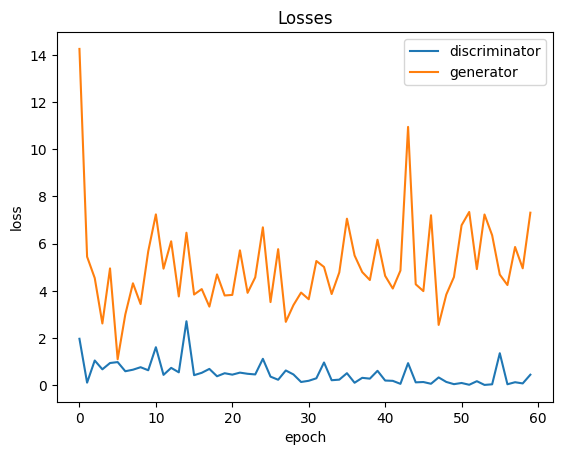

In [22]:
plt.plot(losses_d, "-", label="discriminator")
plt.plot(losses_g, "-", label="generator")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Losses")

Text(0.5, 1.0, 'Scores')

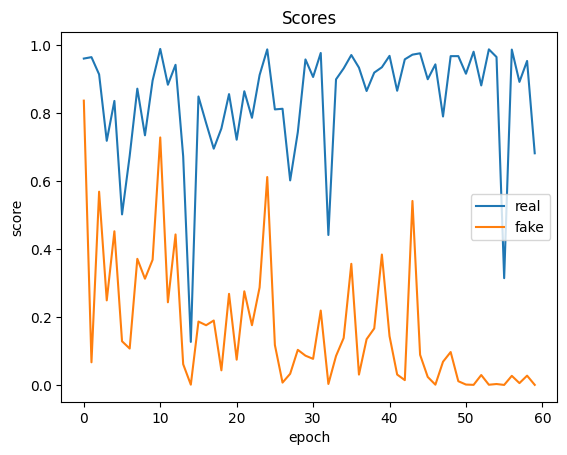

In [25]:
plt.plot(real_scores, "-", label="real")
plt.plot(fake_scores, "-", label="fake")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend()
plt.title("Scores")

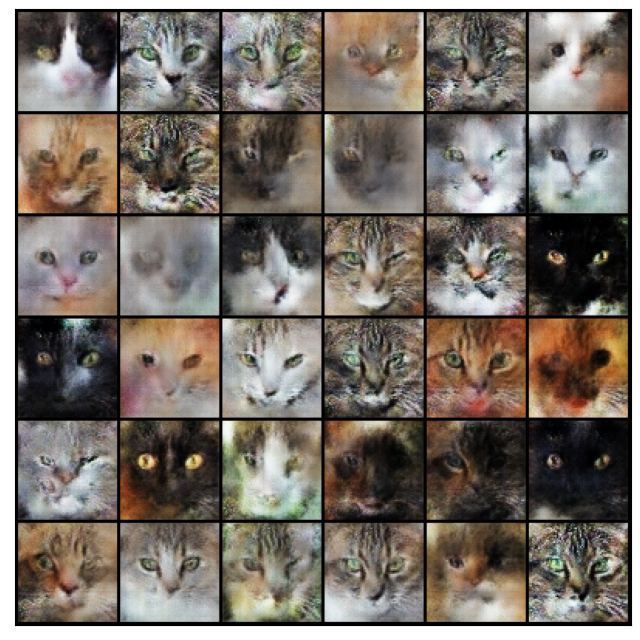

In [19]:
show_images(generator(random_latent))